In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from transforms import *
from FISTA_RMS import *
from rm_clean import *
from matplotlib import rc
from performance import *

rc('font',**{'family':'serif'})
rc('text', usetex=True)

In [2]:
#Constants and scales for lambda2 and phi
c = 2.99792458e8
m = 126 #Number of channels
w_min = 3.6 #wavelength start cm
w_max = 50.0 #wavelength end cm

w2_min = (w_min/100.0)*(w_min/100.0) #Min lambda2 in m^2
w2_max = (w_max/100.0)*(w_max/100.0) #Max lambda2 in m^2

lambda2_ref = (w2_max+w2_min)/2 #Reference lambda2 -> lambda2_0
delta_lambda2 = (w2_max-w2_min)/(m-1) #delta lambda2

lambda2 = np.arange(w2_min, w2_max, delta_lambda2) #lambda2 sampling

delta_phi = 2*np.sqrt(3)/(w2_max-w2_min) # delta phi as Brentjens et al - FWHM of the main peak of the RMSF

phi_max = np.sqrt(3)/delta_lambda2 #Phi max as Brentjens et al

times = 4

phi_r = delta_phi/times #The resolution is 4 times less than the FWHM of the main peak of the RMSF

temp = np.int(np.floor(2*phi_max/phi_r)) #we calculate the number of grid points N
n = temp-np.mod(temp,32) #We make sure that n is a even number to use the wavelet transform

phi_r = 2*phi_max/n; 
phi = phi_r*np.arange(-(n/2),(n/2), 1) #phi sampling

In [3]:
#Constructing simulated thin and thick sources
#2 complex thin sources -> spikes and 1 thick source
sources_F = [-4+1j*3, 10-1j*4] #Jy
sources_F3 = 2-1j*6 #Jy
#Positions in phi
pos_F = [-58, -30] #spikes position
pos_F3 = [41,100] #Thick source interval

F = np.zeros(n) + 1j*np.zeros(n) # We create our Faraday dispersion function
W = np.ones(m) # We assume that our observation windows has uniform weights for the m channels
K = 1/np.sum(W); #Normalising constant

#We create our spikes and thick sources in F
for i in range(0,len(sources_F)):
    ps_idx = (np.abs(phi-pos_F[i])).argmin()
    F[ps_idx] = sources_F[i]
    
ps_idx_1 = (np.abs(phi-pos_F3[0])).argmin()
ps_idx_2 = (np.abs(phi-pos_F3[1])).argmin()
F[ps_idx_1:ps_idx_2] = sources_F3

In [4]:
#We go to lambda2 space - This is not used, is only to plot it if you want
P = form_P(F, phi, lambda2, 0, m)
#We get the RMSF
R = form_R(K, W, phi, lambda2, lambda2_ref, n)
#We get the complex polarized emission
P_meas = form_P_meas(W, F, phi, lambda2, 0, m)
#We get the dirty Faraday dispersion function
F_dirty = form_F_dirty(K, P_meas, phi, lambda2, 0, n)

In [5]:
#We define our FISTA arguments
soft_thresholds = [0.8, 0.8, 0.8]

In [6]:
#We reconstruct our Faraday dispersion function using our three FISTA Algorithms
#You can change the soft_threshold and iterations arguments if you want
F_recon_thin = Ultimate_FISTAMix(P_meas, W, K, phi, lambda2, 0, m, n, soft_thresholds[0], 1e-5, "Thin", 1e-12)
F_recon_thick = Ultimate_FISTAMix(P_meas, W, K, phi, lambda2, 0, m, n, soft_thresholds[1], 1e-5, "Thick", 1e-12)
F_recon_mix = Ultimate_FISTAMix(P_meas, W, K, phi, lambda2, 0, m, n, soft_thresholds[2], 1e-5, "Both", 1e-12)

Iteration -  0 :  500.21033755942034
Iteration -  1000 :  64.14159605920378
Iteration -  2000 :  63.512260222874154
Iteration -  3000 :  62.884472344022015
Iteration -  4000 :  62.25855862203797
Iteration -  5000 :  61.622136737806514
Iteration -  6000 :  60.95639742531666
Iteration -  7000 :  60.30844551364352
Iteration -  8000 :  59.64771531068393
Iteration -  9000 :  58.98331532617157
Iteration -  10000 :  58.320551456252645
Iteration -  11000 :  57.658736855390266
Iteration -  12000 :  57.00037665199445
Iteration -  13000 :  56.34599042209269
Iteration -  14000 :  55.69366550663679
Iteration -  15000 :  55.02147826307861
Iteration -  16000 :  54.34817579670662
Iteration -  17000 :  53.677066935275604
Iteration -  18000 :  53.00823991286392
Iteration -  19000 :  52.34177272714183
Iteration -  20000 :  51.67775618230526
Iteration -  21000 :  51.01628622053745
Iteration -  22000 :  50.3574632155717
Iteration -  23000 :  49.70067487268502
Iteration -  24000 :  48.98349994347095
Iterati

Iteration -  44000 :  23.154977939048134
Iteration -  45000 :  22.62912321970957
Iteration -  46000 :  22.106098310460002
Iteration -  47000 :  21.58610890861197
Iteration -  48000 :  21.06937976308031
Iteration -  49000 :  20.556156738820285
Iteration -  50000 :  20.04670912206067
Iteration -  51000 :  19.541332192598972
Iteration -  52000 :  19.040350090842715
Iteration -  53000 :  18.52332654340795
Iteration -  54000 :  17.994343770773256
Iteration -  55000 :  17.470079245252567
Iteration -  56000 :  16.94154199326858
Iteration -  57000 :  16.37523913849456
Iteration -  58000 :  15.813865460934139
Iteration -  59000 :  15.252624052839796
Iteration -  60000 :  14.69835326824211
Iteration -  61000 :  14.14603815032717
Iteration -  62000 :  13.597026219678426
Iteration -  63000 :  13.026688825994095
Iteration -  64000 :  12.4284400742043
Iteration -  65000 :  11.813419609440178
Iteration -  66000 :  11.207560521813543
Iteration -  67000 :  10.612431457551173
Iteration -  68000 :  10.01

In [7]:
#We define RM_CLEAN arguments
rm_clean_it = 10000
gain = 0.1
threshold = 1e-8

In [8]:
#We run RM_CLEAN
F_recon_rmclean = RM_CLEAN(P_meas, R, W, K, phi, lambda2, lambda2_ref, m, n, rm_clean_it, gain, threshold, cross_corr=True)

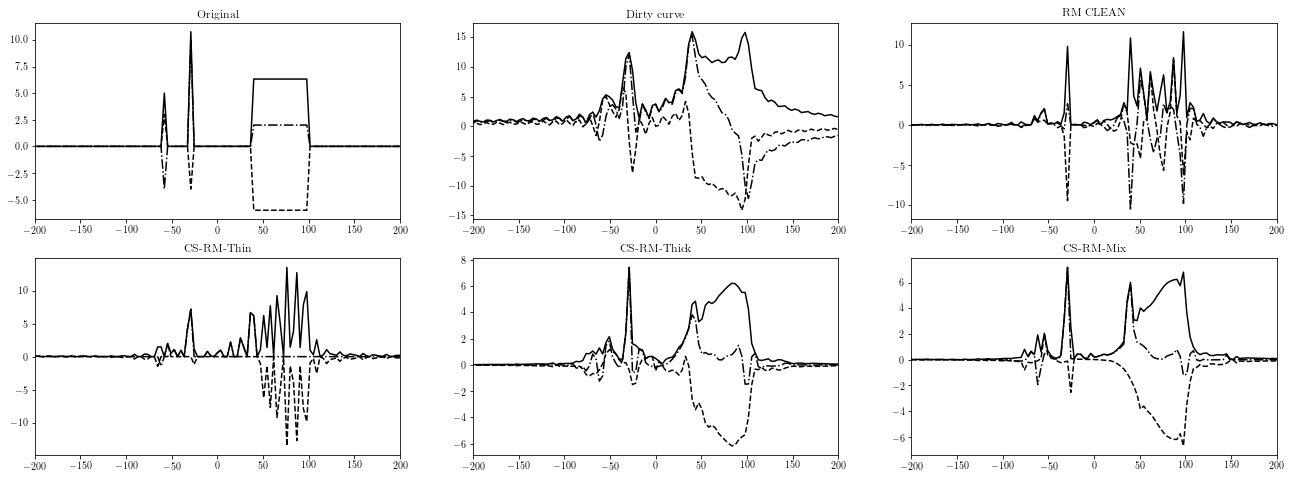

In [9]:
#We plot the results
f, axarr = plt.subplots(2, 3)

axarr[0,0].plot(phi, np.abs(F), 'k-')
axarr[0,0].plot(phi, F.real, 'k-.')
axarr[0,0].plot(phi, F.imag, 'k--')
axarr[0,0].set_ylim([None, None])
axarr[0,0].set_xlim([-200, 200])
axarr[0,0].set(title='Original')

axarr[0,1].plot(phi, np.abs(F_dirty), 'k-')
axarr[0,1].plot(phi, F_dirty.real, 'k-.')
axarr[0,1].plot(phi, F_dirty.imag, 'k--')
axarr[0,1].set_ylim([None, None])
axarr[0,1].set_xlim([-200, 200])
axarr[0,1].set(title='Dirty curve')

axarr[0,2].plot(phi, np.abs(F_recon_rmclean), 'k-')
axarr[0,2].plot(phi, F_recon_rmclean.real, 'k-.')
axarr[0,2].plot(phi, F_recon_rmclean.imag, 'k--')
axarr[0,2].set_ylim([None, None])
axarr[0,2].set_xlim([-200, 200])
axarr[0,2].set(title='RM CLEAN')

axarr[1,0].plot(phi, np.abs(F_recon_thin), 'k-')
axarr[1,0].plot(phi, F_recon_thin.real, 'k-.')
axarr[1,0].plot(phi, F_recon_thin.imag, 'k--')
axarr[1,0].set_ylim([None, None])
axarr[1,0].set_xlim([-200, 200])
axarr[1,0].set(title='CS-RM-Thin')

axarr[1,1].plot(phi, np.abs(F_recon_thick), 'k-')
axarr[1,1].plot(phi, F_recon_thick.real, 'k-.')
axarr[1,1].plot(phi, F_recon_thick.imag, 'k--')
axarr[1,1].set_ylim([None, None])
axarr[1,1].set_xlim([-200, 200])
axarr[1,1].set(title='CS-RM-Thick')


axarr[1,2].plot(phi, np.abs(F_recon_mix), 'k-')
axarr[1,2].plot(phi, F_recon_mix.real, 'k-.')
axarr[1,2].plot(phi, F_recon_mix.imag, 'k--')
axarr[1,2].set_ylim([None, None])
axarr[1,2].set_xlim([-200, 200])
axarr[1,2].set(title='CS-RM-Mix')

plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.subplots_adjust(bottom=0.5)

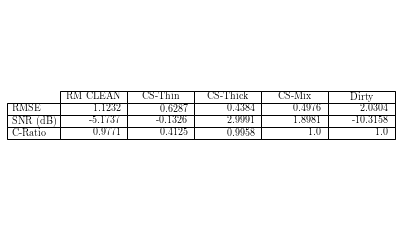

In [10]:
# Tables and plots for Real parts
fig, axs = plt.subplots(1,1)
plt.rcParams["figure.figsize"] = 20,15
collabel=("RM CLEAN", "CS-Thin", "CS-Thick", "CS-Mix", "Dirty")
rows = ("RMSE", "SNR (dB)", "C-Ratio")
data = np.zeros((3,5))

F_orig = F.real
F_rm_clean = F_recon_rmclean.real
F_thin = F_recon_thin.real
F_thick = F_recon_thick.real
F_mix = F_recon_mix.real
F_dirty_re = F_dirty.real

# RMSE

data[0,0] = RMSE(F_orig, F_rm_clean)
data[0,1] = RMSE(F_orig, F_thin)
data[0,2] = RMSE(F_orig, F_thick)
data[0,3] = RMSE(F_orig, F_mix)
data[0,4] = RMSE(F_orig, F_dirty_re)

# SNR

data[1,0] = SNR(F_orig, F_rm_clean)
data[1,1] = SNR(F_orig, F_thin)
data[1,2] = SNR(F_orig, F_thick)
data[1,3] = SNR(F_orig, F_mix)
data[1,4] = SNR(F_orig, F_dirty_re)

# Compressibility Ratio

data[2,0] = CompressibilityRatio(F_rm_clean)
data[2,1] = CompressibilityRatio(F_thin)
data[2,2] = CompressibilityRatio(F_thick)
data[2,3] = CompressibilityRatio(F_mix)
data[2,4] = CompressibilityRatio(F_dirty_re)

axs.axis('tight')
axs.axis('off')

data = np.round(data, 4)
the_table = axs.table(cellText=data, rowLabels=rows, colLabels=collabel,loc='center')

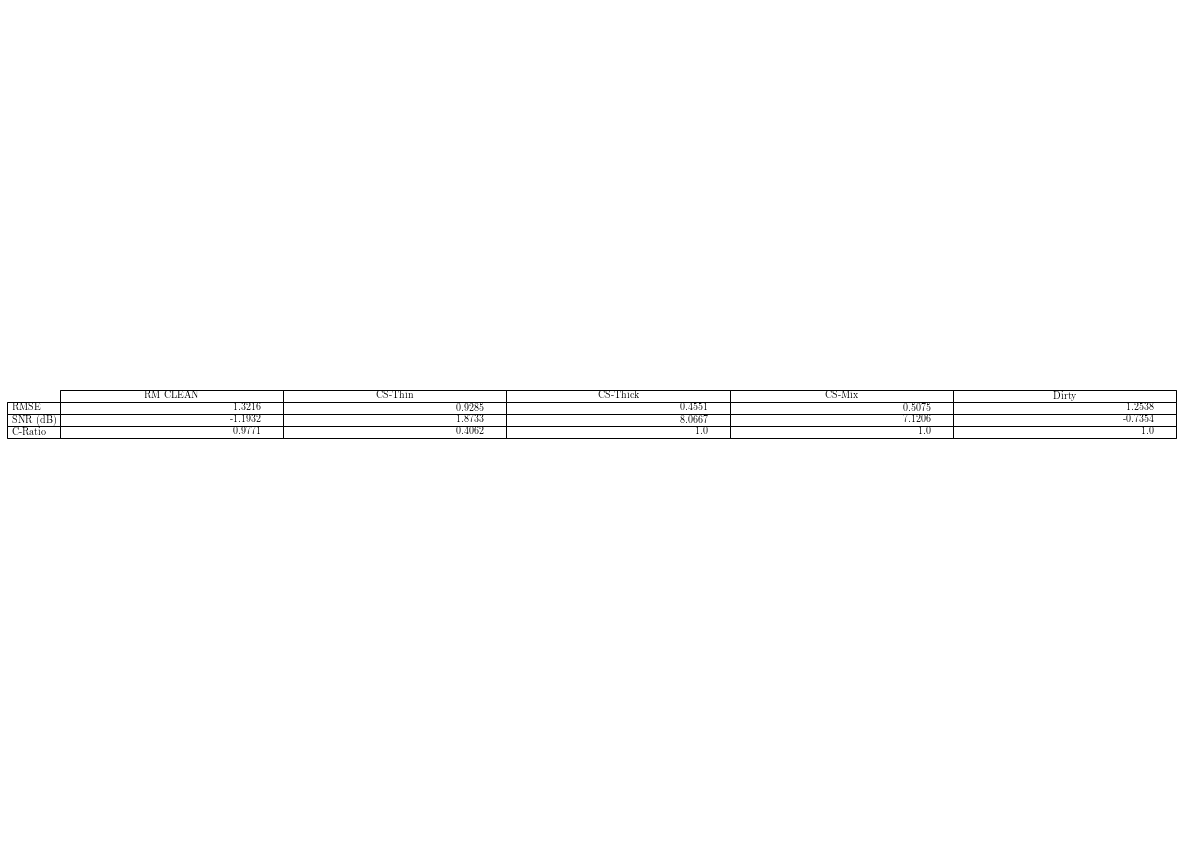

In [11]:
# Tables and plots for Imaginary parts
fig, axs = plt.subplots(1,1)
plt.rcParams["figure.figsize"] = 8,10
collabel=("RM CLEAN", "CS-Thin", "CS-Thick", "CS-Mix", "Dirty")
rows = ("RMSE", "SNR (dB)", "C-Ratio")
data = np.zeros((3,5))

F_orig = F.imag
F_rm_clean = F_recon_rmclean.imag
F_thin = F_recon_thin.imag
F_thick = F_recon_thick.imag
F_mix = F_recon_mix.imag
F_dirty_img = F_dirty.imag

# RMSE

data[0,0] = RMSE(F_orig, F_rm_clean)
data[0,1] = RMSE(F_orig, F_thin)
data[0,2] = RMSE(F_orig, F_thick)
data[0,3] = RMSE(F_orig, F_mix)
data[0,4] = RMSE(F_orig, F_dirty_img)

# SNR

data[1,0] = SNR(F_orig, F_rm_clean)
data[1,1] = SNR(F_orig, F_thin)
data[1,2] = SNR(F_orig, F_thick)
data[1,3] = SNR(F_orig, F_mix)
data[1,4] = SNR(F_orig, F_dirty_img)

# Compressibility Ratio

data[2,0] = CompressibilityRatio(F_rm_clean)
data[2,1] = CompressibilityRatio(F_thin)
data[2,2] = CompressibilityRatio(F_thick)
data[2,3] = CompressibilityRatio(F_mix)
data[2,4] = CompressibilityRatio(F_dirty_img)

axs.axis('tight')
axs.axis('off')

data = np.round(data, 4)
the_table = axs.table(cellText=data, rowLabels=rows, colLabels=collabel,loc='center')

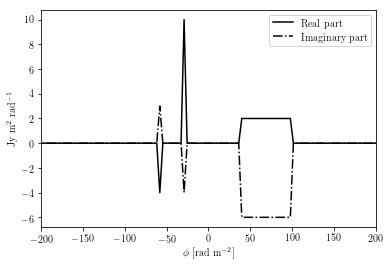

In [19]:
plt.plot(phi, F.real, 'k-')
plt.plot(phi, F.imag, 'k-.')
plt.xlabel(r"$\phi$ [rad m$^{-2}$]")
plt.ylabel(r'Jy m$^2$ rad$^{-1}$')
plt.ylim([None, None])
plt.xlim([-200, 200])
plt.legend((r"Real part", r"Imaginary part"), loc='upper right')

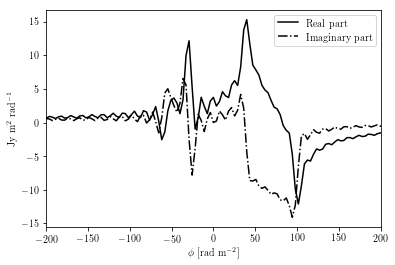

In [20]:
#plt.plot(phi, np.abs(F), 'k-')
plt.plot(phi, F_dirty.real, 'k-')
plt.plot(phi, F_dirty.imag, 'k-.')
plt.xlabel(r"$\phi$ [rad m$^{-2}$]")
plt.ylabel(r'Jy m$^2$ rad$^{-1}$')
plt.ylim([None, None])
plt.xlim([-200, 200])
plt.legend((r"Real part", r"Imaginary part"), loc='upper right')

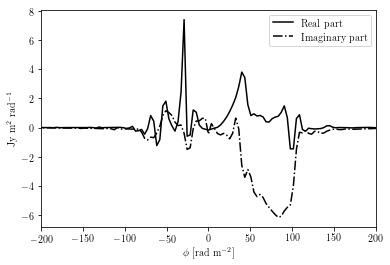

In [21]:
#plt.plot(phi, np.abs(F), 'k-')
plt.plot(phi, F_recon_thick.real, 'k-')
plt.plot(phi, F_recon_thick.imag, 'k-.')
plt.xlabel(r"$\phi$ [rad m$^{-2}$]")
plt.ylabel(r'Jy m$^2$ rad$^{-1}$')
plt.ylim([None, None])
plt.xlim([-200, 200])
plt.legend((r"Real part", r"Imaginary part"), loc='upper right')

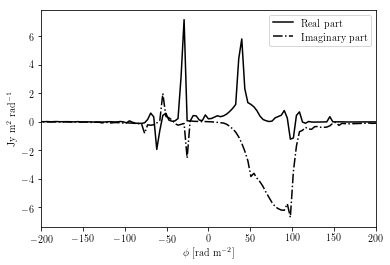

In [22]:
#plt.plot(phi, np.abs(F), 'k-')
plt.plot(phi, F_recon_mix.real, 'k-')
plt.plot(phi, F_recon_mix.imag, 'k-.')
plt.xlabel(r"$\phi$ [rad m$^{-2}$]")
plt.ylabel(r'Jy m$^2$ rad$^{-1}$')
plt.ylim([None, None])
plt.xlim([-200, 200])
plt.legend((r"Real part", r"Imaginary part"), loc='upper right')

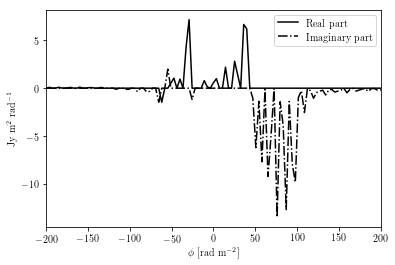

In [23]:
#plt.plot(phi, np.abs(F), 'k-')
plt.plot(phi, F_recon_thin.real, 'k-')
plt.plot(phi, F_recon_thin.imag, 'k-.')
plt.xlabel(r"$\phi$ [rad m$^{-2}$]")
plt.ylabel(r'Jy m$^2$ rad$^{-1}$')
plt.ylim([None, None])
plt.xlim([-200, 200])
plt.legend((r"Real part", r"Imaginary part"), loc='upper right')